In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

from src.dataset.dataset import FurnitureImageDataset
from src.behavior import get_actor
from src.behavior.base import Actor
from src.common.files import get_processed_paths
from src.common.control import ControlMode
from src.dataset.normalizer import LinearNormalizer
import torch
from pathlib import Path
from tqdm import trange, tqdm
from src.common.pytorch_util import dict_apply
from omegaconf import OmegaConf, DictConfig
from src.visualization.render_mp4 import data_to_video, create_mp4_jupyter
from wandb import Api
import cv2
import numpy as np

from typing import Dict


from torch.utils.data import DataLoader


api = Api()

In [3]:
def convert_state_dict(state_dict):
    if not any(k.startswith("encoder1.0") for k in state_dict.keys()) and not any(
        k.startswith("encoder1.model.nets.3") for k in state_dict.keys()
    ):
        print("Dict already in the correct format")
        return

    # Change all instances of "encoder1.0" to "encoder1" and "encoder2.0" to "encoder2"
    # and all instances of "encoder1.1" to encoder1_proj and "encoder2.1" to "encoder2_proj"
    for k in list(state_dict.keys()):
        if k.startswith("encoder1.0"):
            new_k = k.replace("encoder1.0", "encoder1")
            state_dict[new_k] = state_dict.pop(k)
        elif k.startswith("encoder2.0"):
            new_k = k.replace("encoder2.0", "encoder2")
            state_dict[new_k] = state_dict.pop(k)
        elif k.startswith("encoder1.1"):
            new_k = k.replace("encoder1.1", "encoder1_proj")
            state_dict[new_k] = state_dict.pop(k)
        elif k.startswith("encoder2.1"):
            new_k = k.replace("encoder2.1", "encoder2_proj")
            state_dict[new_k] = state_dict.pop(k)

    return state_dict

In [4]:
run = api.run("sweeps/runs/brsbq5d2")
cfg = OmegaConf.create(run.config)

In [5]:
[file for file in run.files() if file.name.endswith(".pt")]

[<File models/honest-sweep-31/actor_chkpt_best_test_loss.pt (application/vnd.snesdev-page-table) 1.1GiB>]

In [6]:
model_wts = (
    [file for file in run.files() if file.name.endswith(".pt")][0]
    .download(replace=False, exist_ok=True)
    .name
)

In [7]:
file_paths = get_processed_paths(
    environment="sim",
    task="one_leg",
    demo_outcome="success",
    demo_source="teleop",
    randomness="low",
)

normalizer = LinearNormalizer(
    control_mode=ControlMode.delta,
)

# Make the dataset
dataset_success = FurnitureImageDataset(
    dataset_paths=file_paths,
    action_horizon=8,
    pred_horizon=32,
    augment_image=False,
    obs_horizon=1,
    control_mode=ControlMode.delta,
    data_subset=None,
    normalizer=normalizer,
)

Found the following paths:
    /data/scratch/ankile/furniture-data/processed/sim/one_leg/teleop/low/success.zarr


Loading zarr files:   0%|          | 0/1 [00:00<?, ?it/s]



































































Loading zarr files: 100%|██████████| 1/1 [00:31<00:00, 31.87s/it]


Loading dataset of 50 episodes


In [66]:
file_paths = get_processed_paths(
    environment="sim",
    task="one_leg",
    demo_outcome="failure",
    demo_source="rollout",
    randomness="low",
)

normalizer = LinearNormalizer(
    control_mode=ControlMode.delta,
)

# Make the dataset
dataset_failure = FurnitureImageDataset(
    dataset_paths=file_paths,
    action_horizon=8,
    pred_horizon=32,
    augment_image=False,
    obs_horizon=1,
    control_mode=ControlMode.delta,
    data_subset=None,
    normalizer=normalizer,
)

Found the following paths:
    /data/scratch/ankile/furniture-data/processed/sim/one_leg/rollout/low/failure.zarr


Loading zarr files:   0%|          | 0/1 [00:00<?, ?it/s]

























Loading zarr files: 100%|██████████| 1/1 [00:10<00:00, 10.29s/it]

Loading dataset of 10 episodes


In [8]:
actor = get_actor(
    device="cuda",
    normalizer=normalizer.get_copy(),
    config=cfg,
)

actor.load_state_dict(convert_state_dict(torch.load(model_wts)))

/data/scratch/ankile/miniconda3/envs/rlgpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using inference steps: 16
Total parameters: 304.09M
normalizer: 0.00M parameters
encoder1: 11.19M parameters
encoder2: 11.19M parameters
encoder1_proj: 0.03M parameters
encoder2_proj: 0.03M parameters
model: 281.64M parameters
loss_fn: 0.00M parameters


<All keys matched successfully>

In [9]:
f"Number of episodes: {len(dataset_success.episode_ends)}, number of images: {len(dataset_success)}, final episode_end: {dataset_success.episode_ends[-1]}"

'Number of episodes: 50, number of images: 27820, final episode_end: 29020'

In [10]:
dataset_success.skills.sum()

200

## Look at some example predicted actions

NBNB: Surgical change to _normalized_action to allow sampling of the action mode
torch.Size([10])
tensor([ 2.3591e-03, -4.0874e-04, -2.7251e-03,  9.9976e-01,  1.6189e-02,
         1.2914e-02, -1.6599e-02,  9.9857e-01, -2.2565e-02,  9.9868e-01])
tensor([0.0053, 0.0011, 0.0050, 0.0007, 0.0188, 0.0158, 0.0201, 0.0017, 0.0265,
        0.0030])
tensor([ 2.2319e+00, -2.5979e+00, -1.8509e+00,  7.2325e-04,  1.1603e+00,
         1.2272e+00, -1.2109e+00,  1.6673e-03, -1.1758e+00,  2.9644e-03])
0.009516711
0.0057427157
0.6034349


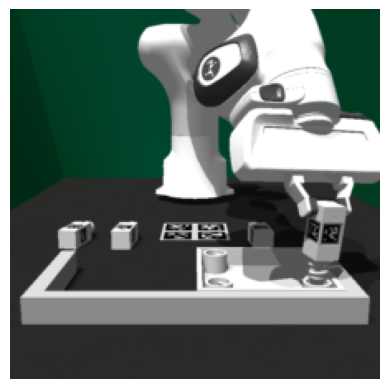

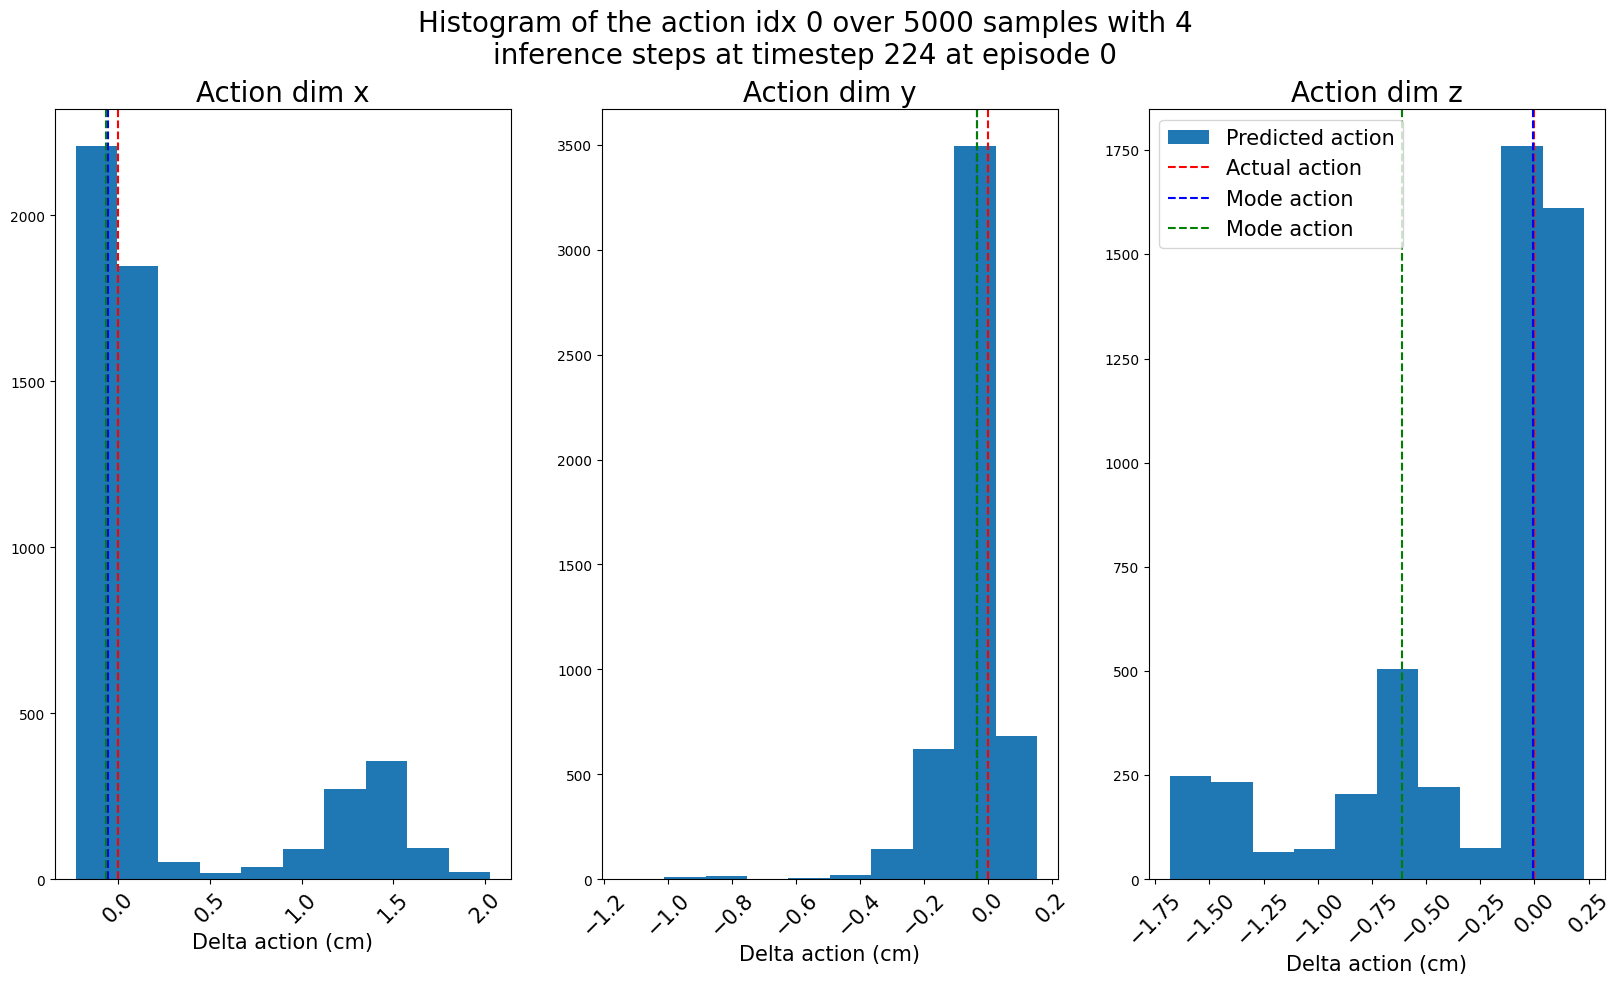

In [94]:
def sample_actions(batch: Dict[str, torch.Tensor], actor: Actor, n_samples: int):
    with torch.no_grad():
        nobs: torch.Tensor = actor._training_obs(batch)

        # Repeat the nobs n_samples times to get a good average
        nobs = nobs.repeat(n_samples, 1)

        # Predict normalized action
        naction = actor._normalized_action(nobs)

        # unnormalize action
        # (B, pred_horizon, action_dim)
        actions = actor.normalizer(naction, "action", forward=False)[:, :8].cpu()
    return actions


def plot_action_histogram(
    dataset, ep_idx, insertion_offset=None, timestep=None, plot_emp_mode=False
):

    # Find the end of the first episode
    ep_start = dataset.episode_ends[ep_idx - 1] if ep_idx > 0 else 0
    ep_end = dataset.episode_ends[ep_idx]

    if insertion_offset is not None:
        # Find the index of the insertion action
        insertion_skill_idx = 3

        # Find the index of the 3rd time skills is 1
        insertion_idx = np.where(dataset.skills[ep_start:ep_end] == 1)[0][
            insertion_skill_idx
        ]

        timestep = ep_start + insertion_idx - insertion_offset
    elif timestep is not None:
        timestep = ep_start + timestep
    else:
        raise Exception

    batch = dataset[timestep]

    batch = dict_apply(batch, lambda x: x.to("cuda", non_blocking=True).unsqueeze(0))

    n_samples = 5000
    actor.inference_steps = 4

    actions = sample_actions(batch, actor, n_samples=n_samples)

    unnormalized_action_taken = actor.normalizer(
        batch["action"][0, :8, :], "action", forward=False
    ).cpu()

    # Show an image from the batch
    plt.imshow(batch["color_image2"][0][0].cpu().numpy())

    # Turn of the axis
    plt.axis("off")
    # Calculate the mean and std of the actions (look at only the first action)
    mean = actions.mean(dim=0)[0]
    std = actions.std(dim=0)[0]

    # Calculate the magnitude of the xyz of the actions
    action_mags = np.linalg.norm(actions.numpy()[:, :, :3].reshape(-1, 3), axis=1)

    # Calculate the mean and std of the action magnitudes
    mean_mag = action_mags.mean()
    std_mag = action_mags.std()

    print(mean.shape)

    print(mean)
    print(std)
    print(std / mean)

    print(mean_mag)
    print(std_mag)
    print(std_mag / mean_mag)

    if plot_emp_mode:
        from sklearn.neighbors import KernelDensity
        from scipy.signal import argrelextrema

        f_actions = actions.reshape((n_samples, 8 * 10)).numpy()

        # Assuming actions_np is the NumPy array representation of your data
        kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(f_actions)
        scores = kde.score_samples(f_actions)

        # Find local maxima
        maxima_indices = argrelextrema(scores, np.greater)[0]
        modes = f_actions[maxima_indices]

        mode_action1 = modes[0].reshape((8, 10))
        mode_action2 = actions.mode(dim=0).values

    # Show a histogram over the n samples for each of the x, y, z, and the magnitude of the action
    # Control what action in the prediction sequence to look at [0, 7]
    histogram_action_index = 0

    fig, axs = plt.subplots(1, 3, figsize=(20, 10))
    for i, coord in enumerate(["x", "y", "z"]):
        ax = axs[i]
        ax.hist(
            actions[:, histogram_action_index, i].cpu().numpy() * 100,
            label="Predicted action",
        )
        ax.set_title(f"Action dim {coord}", fontsize=20)
        # Add the actual action take as a vertical line
        ax.axvline(
            unnormalized_action_taken[histogram_action_index, i].numpy() * 100,
            color="r",
            linestyle="--",
            label="Actual action",
        )

        if plot_emp_mode:
            ax.axvline(
                mode_action1[histogram_action_index, i] * 100,
                color="b",
                linestyle="--",
                label="Mode action",
            )
            ax.axvline(
                mode_action2[histogram_action_index, i] * 100,
                color="g",
                linestyle="--",
                label="Mode action",
            )

        # Set the x-axis tixck labels at an angle and increase the font size
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            tick.set_fontsize(15)

        # Set label on the x-axis
        ax.set_xlabel("Delta action (cm)", fontsize=15)

    axs[-1].legend(fontsize=15)

    fig.suptitle(
        f"Histogram of the action idx {histogram_action_index} over {n_samples} samples with {actor.inference_steps}\ninference steps at timestep {timestep - ep_start} at episode {ep_idx}",
        fontsize=20,
    )

    plt.show()


plot_action_histogram(dataset_success, 0, insertion_offset=20, plot_emp_mode=True)

torch.Size([10])
tensor([ 0.0012, -0.0020, -0.0144,  0.9994, -0.0132,  0.0320,  0.0113,  0.9997,
         0.0034,  0.6887])
tensor([6.6740e-04, 1.0368e-03, 6.8020e-03, 3.8891e-04, 5.1011e-03, 1.7288e-02,
        4.8680e-03, 3.9087e-04, 4.2561e-03, 6.5303e-01])
tensor([ 5.5896e-01, -5.2716e-01, -4.7167e-01,  3.8913e-04, -3.8699e-01,
         5.3977e-01,  4.3040e-01,  3.9100e-04,  1.2653e+00,  9.4819e-01])
0.0028152731
0.0056096027
1.9925607


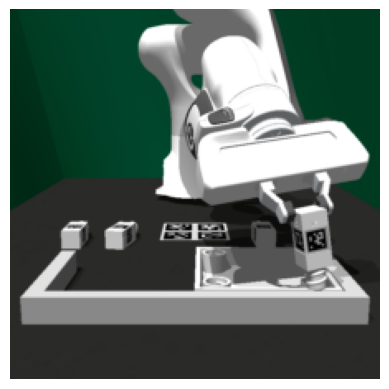

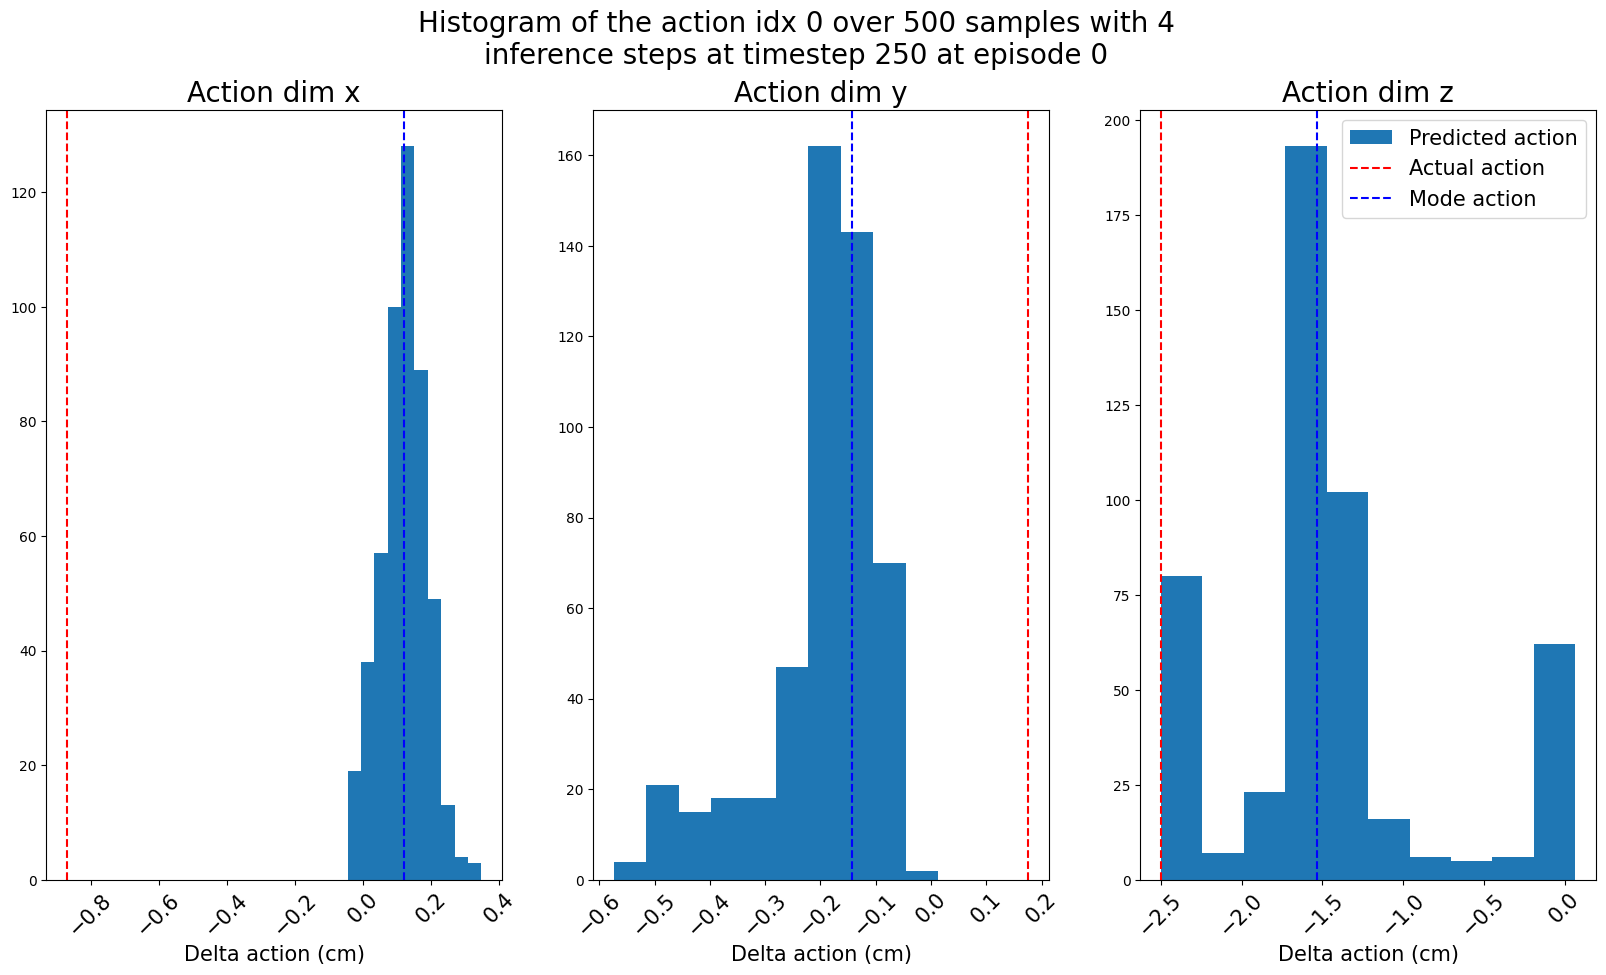

In [87]:
plot_action_histogram(dataset_failure, 0, timestep=250, plot_emp_mode=True)

## Look at the coefficient of variation of the predicted actions across an episode

In [16]:
def calculate_epi_stats(
    dataset, actor, ep_start, ep_end, action_batch=8, samples=100, batch_size=100
):
    means = []
    stds = []
    cvs = []
    actuals = []

    for i in trange(ep_start, ep_end, batch_size * action_batch):
        end_idx = min(i + batch_size * action_batch, ep_end)

        # Manually make a batch
        batch = {
            k: torch.stack([dataset[i][k] for i in range(i, end_idx, action_batch)])
            for k in dataset[0].keys()
        }

        with torch.no_grad():
            batch = dict_apply(batch, lambda x: x.to("cuda", non_blocking=True))

            actual_action = actor.normalizer(
                batch["action"][:, :8].reshape(-1, 10),
                "action",
                forward=False,
            ).cpu()

            # Store the actual actions
            actuals.extend(actual_action)

            # Shape of nobs is (B, obs_dim)
            nobs = actor._training_obs(batch)

            # Repeat the nobs 100 times for each sample in the batch
            # Shape of nobs is now (B, 1, obs_dim)
            nobs = nobs.unsqueeze(1)

            # Repeat the nobs {samples} times to get a good average
            # Shape of nobs is now (B, samples, obs_dim)
            nobs = nobs.repeat(1, samples, 1)

            # Reshape to (B * samples, obs_dim)
            nobs = nobs.view(-1, nobs.shape[-1])

            # Predict normalized action
            # Shape of naction is (B * samples, pred_horizon, action_dim)
            naction = actor._normalized_action(nobs)

            # Reshape to (B, samples, pred_horizon, action_dim)
            naction = naction.view(-1, samples, naction.shape[-2], naction.shape[-1])

            # unnormalize action
            # (B, samples, pred_horizon, action_dim)
            actions = actor.normalizer(naction, "action", forward=False)[:, :, :8].cpu()

        # Calculate the mean and std of the actions over the samples dimension (axis=1)

        mean = actions.mean(dim=1).reshape(-1, 10)
        std = actions.std(dim=1).reshape(-1, 10)

        # Add to the list
        means.extend(mean)
        stds.extend(std)
        cvs.extend(std / mean)

    means = torch.stack(means)[: ep_end - ep_start]
    stds = torch.stack(stds)[: ep_end - ep_start]
    cvs = torch.stack(cvs)[: ep_end - ep_start]
    actuals = torch.stack(actuals)[: ep_end - ep_start]

    return means, stds, cvs, actuals


means, stds, cvs, actuals = calculate_epi_stats(
    dataset, actor, ep_start, ep_end, action_batch=8, samples=100, batch_size=100
)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:04<00:00,  4.59s/it]


In [17]:
means.shape, stds.shape, cvs.shape, actuals.shape

(torch.Size([535, 10]),
 torch.Size([535, 10]),
 torch.Size([535, 10]),
 torch.Size([535, 10]))

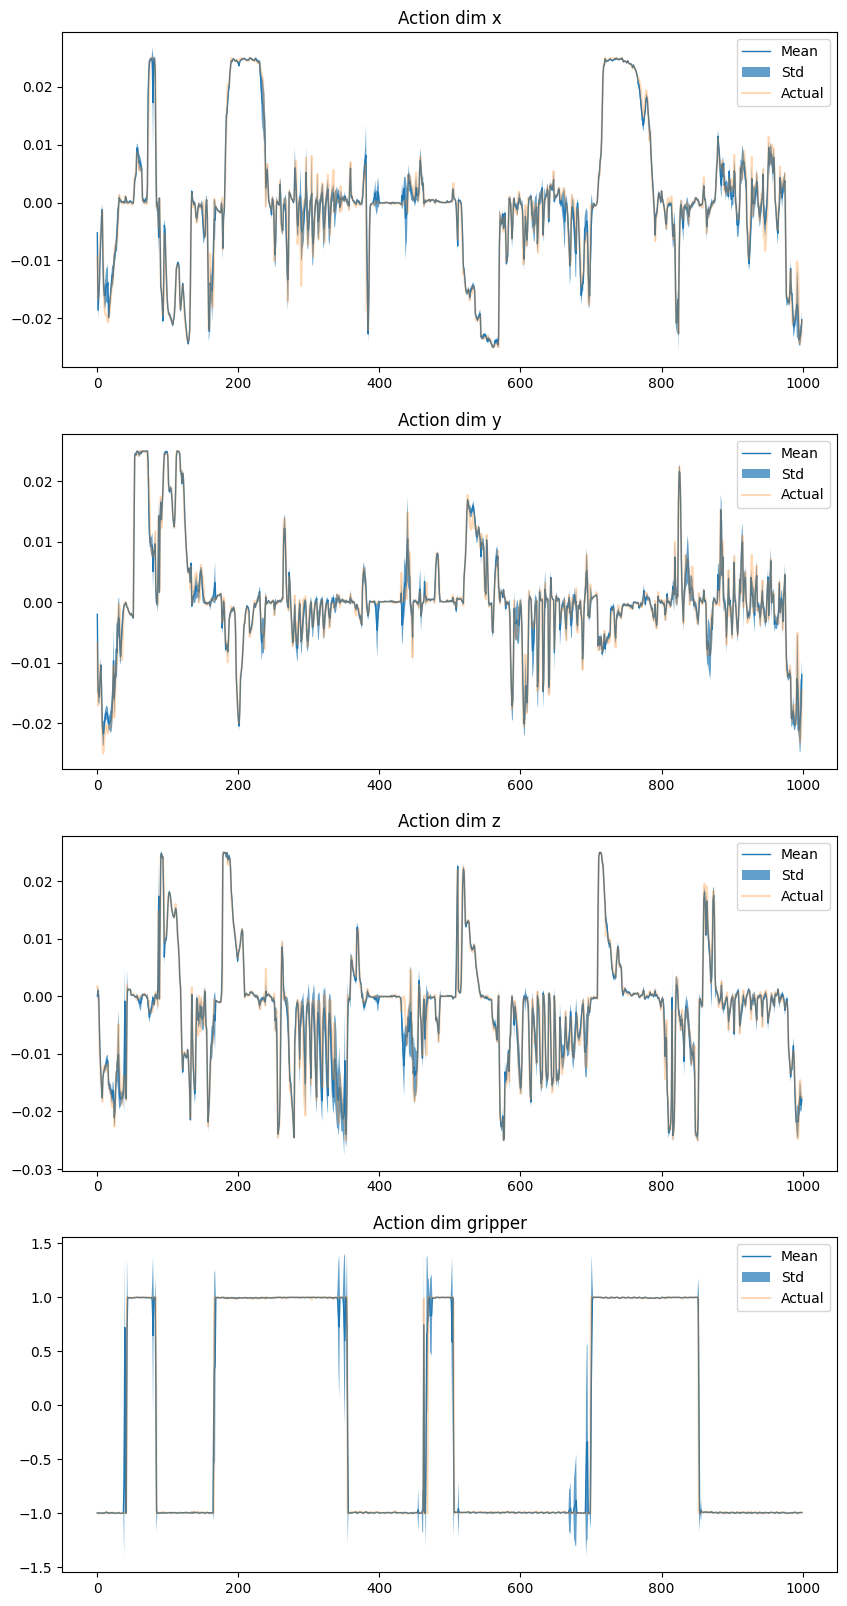

In [36]:
# Do the same as above but focus on xyz deltas
# Plot the mean and std over time for each of the 8 action dimensions where the mean is a line and the std is a shaded area
def plot_episode(means, stds, actuals, insertion_idx=None):
    fig, axs = plt.subplots(4, 1, figsize=(10, 20))
    for i, coord in zip([0, 1, 2, -1], ["x", "y", "z", "gripper"]):
        ax = axs[i]
        ax.plot(means[:, i].cpu().numpy(), label="Mean", linewidth=1)
        ax.fill_between(
            range(ep_end - ep_start),
            (means - stds)[:, i].cpu().numpy(),
            (means + stds)[:, i].cpu().numpy(),
            alpha=0.7,
            label="Std",
        )

        # Plot the actual actions
        ax.plot(actuals[:, i].cpu().numpy(), label="Actual", alpha=0.3)

        ax.set_title(f"Action dim {coord}")
        ax.legend()

        # Put a vertical line at the insertion_idx
        if insertion_idx is not None:
            ax.axvline(
                insertion_idx,
                color="r",
                linestyle="--",
                label="Insertion idx",
                alpha=0.5,
            )


plot_episode(means, stds, actuals, insertion_idx)

# fig.suptitle(
#     f"Mean and std of the action over {n_samples} samples\nwith {actor.inference_steps} inference steps at timestep {timestep}",
#     fontsize=16,
# )

### Plot only the variance throughout the episode

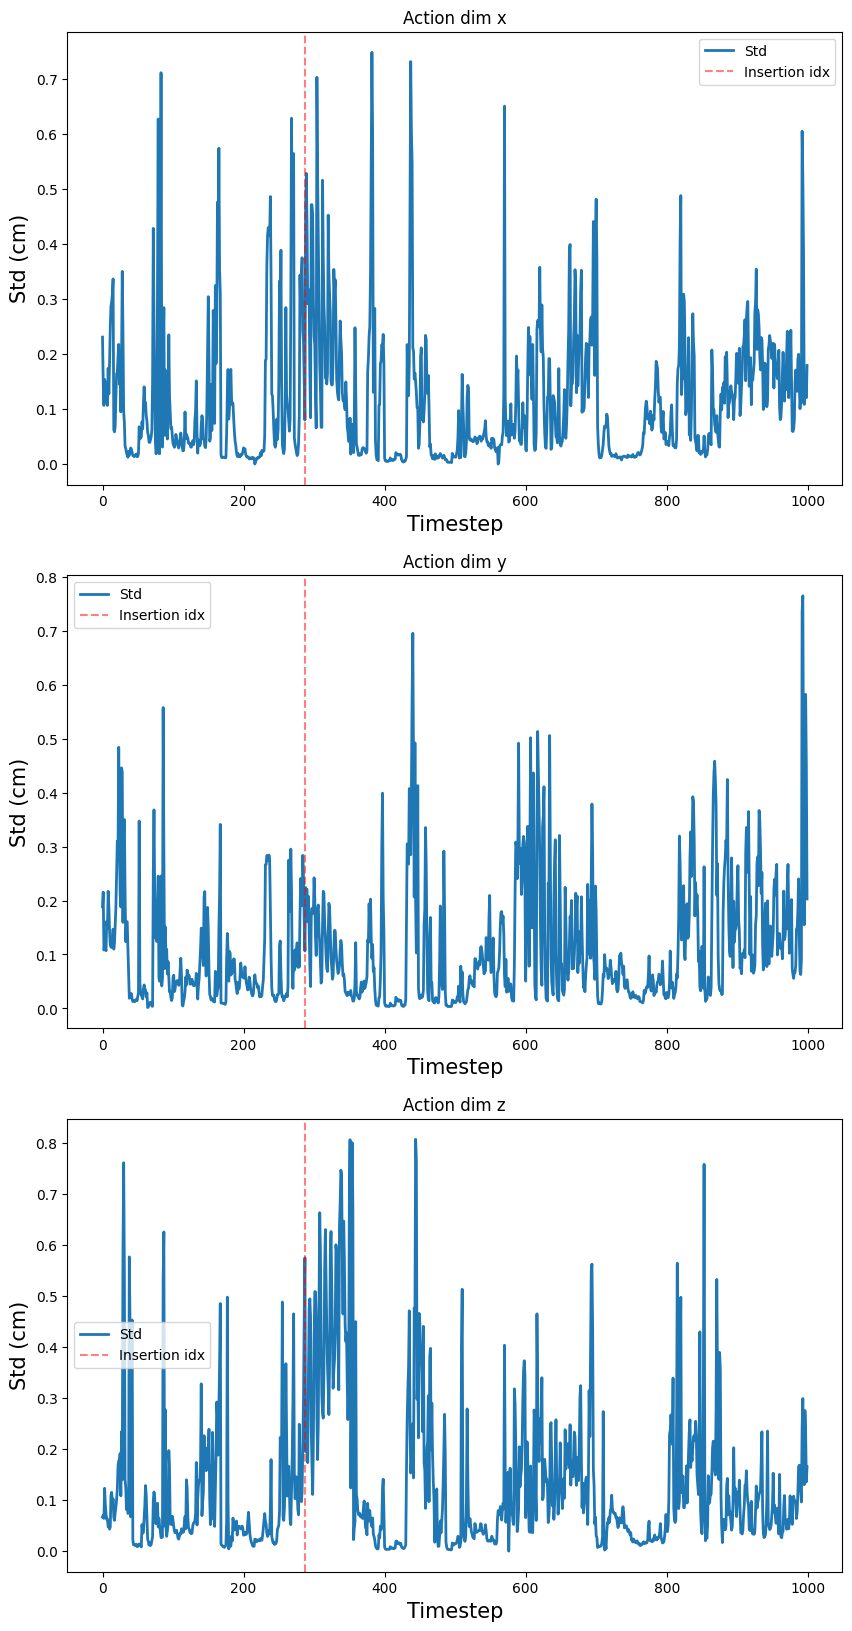

In [163]:
# Plot the standard deviation over time for each of the x, y, and z dimensions
fig, axs = plt.subplots(3, 1, figsize=(10, 20))
for i, coord in enumerate(["x", "y", "z"]):
    ax = axs[i]
    ax.plot(stds[:, i].cpu().numpy() * 100, label="Std", linewidth=2)

    # Put a vertical line at the insertion_idx
    if insertion_idx is not None:
        ax.axvline(
            insertion_idx,
            color="r",
            linestyle="--",
            label="Insertion idx",
            alpha=0.5,
        )

    # Add label to the x-axis
    ax.set_xlabel("Timestep", fontsize=15)

    # Add title to the y-axis
    ax.set_ylabel("Std (cm)", fontsize=15)

    ax.set_title(f"Action dim {coord}")
    ax.legend()

## Load in a dataset of failures to look at something more OOD

In [31]:
file_paths = get_processed_paths(
    environment="sim",
    task="one_leg",
    demo_outcome="failure",
    demo_source="rollout",
    randomness="low",
)

normalizer = LinearNormalizer(
    control_mode=ControlMode.delta,
)

# Make the dataset
dataset_failure = FurnitureImageDataset(
    dataset_paths=file_paths,
    action_horizon=8,
    pred_horizon=32,
    augment_image=False,
    obs_horizon=1,
    control_mode=ControlMode.delta,
    data_subset=None,
    normalizer=normalizer,
)

Found the following paths:
    /data/scratch/ankile/furniture-data/processed/sim/one_leg/rollout/low/failure.zarr


Loading zarr files:   0%|          | 0/1 [00:00<?, ?it/s]




















Loading zarr files: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Loading dataset of 6 episodes


In [32]:
# Find the end of the first episode
ep_idx = 0
ep_start = dataset.episode_ends[ep_idx - 1] if ep_idx > 0 else 0
ep_end = dataset.episode_ends[ep_idx]
failure_idx = dataset.failure_idx[ep_idx]

# Find the index of the insertion action
insertion_skill_idx = 3

# Find the index of the 3rd time skills is 1
insertion_idx = None

ep_start, ep_end, insertion_idx, failure_idx

(0, 1000, None, 338)

In [27]:
means, stds, cvs, actuals = calculate_epi_stats(
    dataset, actor, ep_start, ep_end, action_batch=8, samples=100, batch_size=100
)

torch.Size([10])
tensor([ 5.9972e-04,  8.8505e-05, -6.8308e-04,  9.8702e-01,  1.4738e-02,
         1.6268e-01, -2.6579e-02,  9.9811e-01,  6.2647e-02,  9.9274e-01])
tensor([0.0005, 0.0002, 0.0004, 0.0006, 0.0027, 0.0043, 0.0028, 0.0003, 0.0031,
        0.0044])
tensor([ 8.4672e-01,  2.5455e+00, -5.2377e-01,  5.9778e-04,  1.8352e-01,
         2.6283e-02, -1.0385e-01,  2.5278e-04,  4.9980e-02,  4.4222e-03])
0.0054755826
0.0047330866
0.8643987


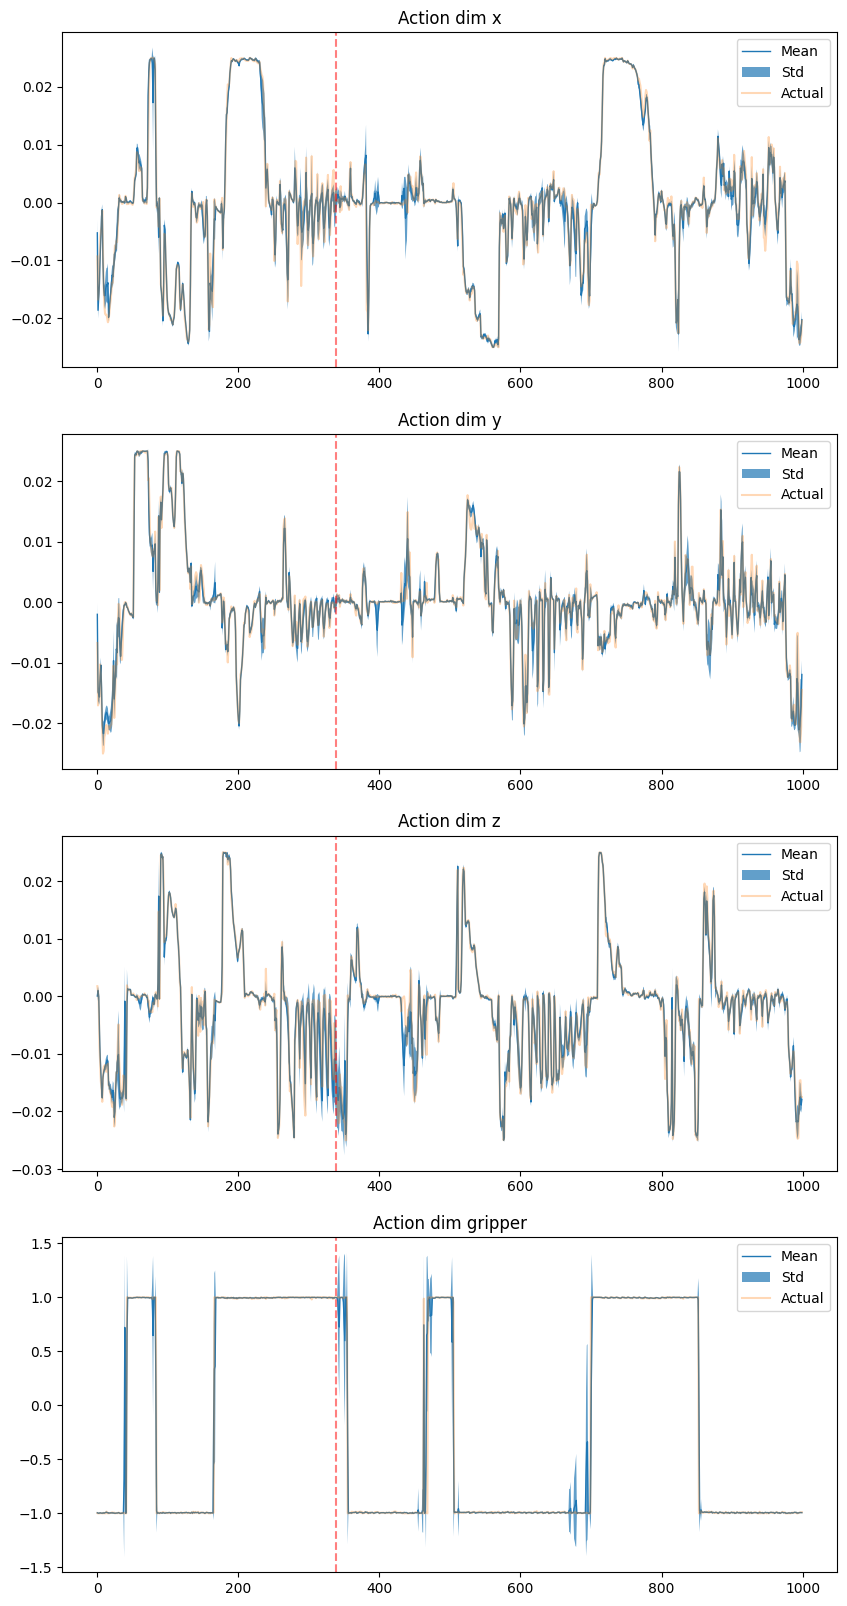

In [37]:
# Plot histograms for the failure dataset
for i in range(600, 499, -10):
    plot_action_histogram(dataset_failure, 1, i)

## What happens if we sample many actions and find something close to the empirical mode?

torch.Size([5000, 8, 10])


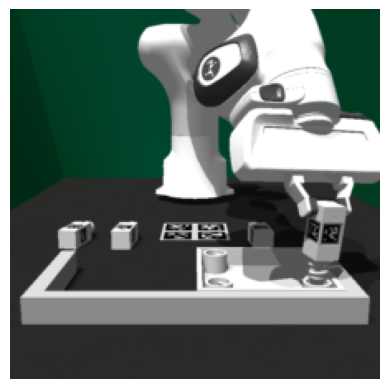

In [53]:
def action_empirical_mode(dataset, ep_idx, insertion_offset):

    # Find the end of the first episode
    ep_start = dataset.episode_ends[ep_idx - 1] if ep_idx > 0 else 0
    ep_end = dataset.episode_ends[ep_idx]

    # Find the index of the insertion action
    insertion_skill_idx = 3

    # Find the index of the 3rd time skills is 1
    insertion_idx = np.where(dataset.skills[ep_start:ep_end] == 1)[0][
        insertion_skill_idx
    ]

    timestep = ep_start + insertion_idx - insertion_offset

    batch = dataset[timestep]

    batch = dict_apply(batch, lambda x: x.to("cuda", non_blocking=True).unsqueeze(0))

    n_samples = 5_000
    actor.inference_steps = 4

    actions = sample_actions(batch, actor, n_samples=n_samples)

    print(actions.shape)

    # unnormalized_action_taken = actor.normalizer(
    #     batch["action"][0, :8, :], "action", forward=False
    # ).cpu()

    # Show an image from the batch
    plt.imshow(batch["color_image2"][0][0].cpu().numpy())

    # Turn of the axis
    plt.axis("off")

    return actions


actions = action_empirical_mode(dataset_success, 0, 20)

f_actions = actions.flatten(start_dim=1).numpy()

In [45]:
# Import tools to do clustering and dimensionality reduction
from sklearn import decomposition, manifold
import umap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [48]:
print("PCA")
pca = decomposition.PCA(n_components=2)
act_pca = pca.fit_transform(f_actions)

print("t-SNE")
tsne = manifold.TSNE(n_components=2)
act_tsne = tsne.fit_transform(f_actions)

print("UMAP")
reducer = umap.UMAP(n_components=2, n_neighbors=15)
act_umap = reducer.fit_transform(f_actions)

print("Isomap")
imap = manifold.Isomap(n_components=2, n_neighbors=10)
act_imap = imap.fit_transform(f_actions)

Text(0.5, 1.0, 'Isomap')

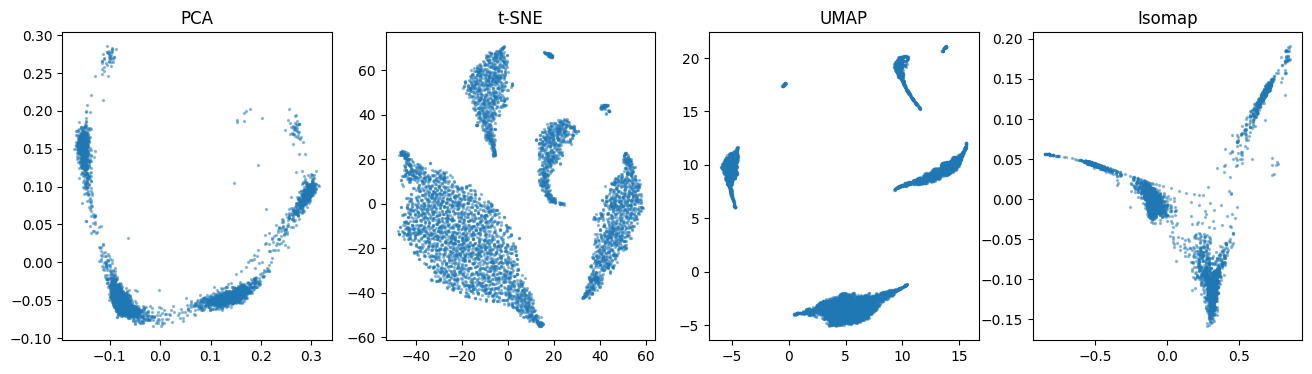

In [52]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

axs[0].scatter(act_pca[:, 0], act_pca[:, 1], alpha=0.4, s=2)
axs[0].set_title("PCA")
axs[1].scatter(act_tsne[:, 0], act_tsne[:, 1], alpha=0.4, s=2)
axs[1].set_title("t-SNE")
axs[2].scatter(act_umap[:, 0], act_umap[:, 1], alpha=0.4, s=2)
axs[2].set_title("UMAP")
axs[3].scatter(act_imap[:, 0], act_imap[:, 1], alpha=0.4, s=2)
axs[3].set_title("Isomap")

### Do some clustering

In [58]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


# Standardize features by removing the mean and scaling to unit variance
actions_std = StandardScaler().fit_transform(f_actions)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=100)  # eps and min_samples need to be tuned
labels = dbscan.fit_predict(actions_std)

# Find the number of clusters and noise points
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Estimated number of clusters: {n_clusters}")
print(f"Estimated number of noise points: {n_noise}")

# Identify the cluster with the highest density
cluster_sizes = [(labels == i).sum() for i in range(n_clusters)]
highest_density_cluster = np.argmax(cluster_sizes)

print(
    f"Cluster with highest density: {highest_density_cluster}, Size: {cluster_sizes[highest_density_cluster]}"
)

Estimated number of clusters: 3
Estimated number of noise points: 294
Cluster with highest density: 0, Size: 3450


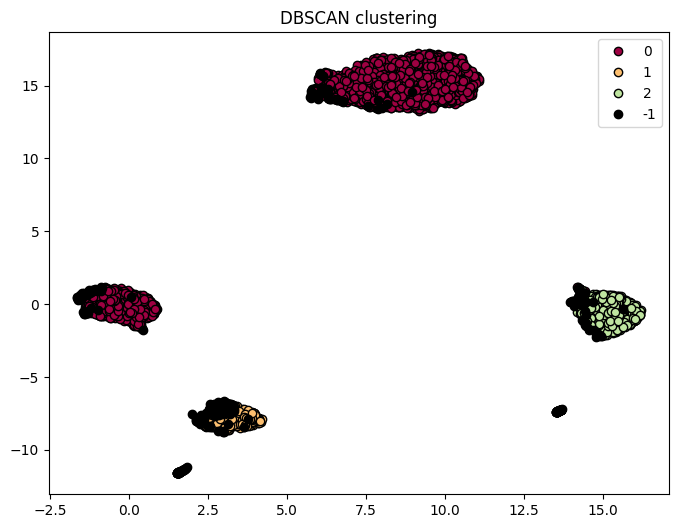

In [61]:
from sklearn.decomposition import PCA

# Reduce the dimensionality for visualization
# pca = PCA(n_components=2)
# actions_reduced = pca.fit_transform(actions_std)

reducer = umap.UMAP(n_components=2, n_neighbors=15)
actions_reduced = reducer.fit_transform(actions_std)

# Plot
plt.figure(figsize=(8, 6))
unique_labels = set(labels)
for k in unique_labels:
    if k == -1:
        # Black used for noise.
        col = "k"
    else:
        col = plt.cm.Spectral(float(k) / n_clusters)
    class_member_mask = labels == k
    xy = actions_reduced[class_member_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
        label=k,
    )

plt.legend()
plt.title("DBSCAN clustering")
plt.show()

In [63]:
from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema

# Assuming actions_np is the NumPy array representation of your data
kde = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(f_actions)
scores = kde.score_samples(f_actions)

# Find local maxima
maxima_indices = argrelextrema(scores, np.greater)[0]
modes = f_actions[maxima_indices]

# `modes` contains points that are local maxima of the estimated density function
modes.shape

(1673, 80)

In [ ]:
from sklearn.cluster import MeanShift

# Apply Mean Shift clustering
mean_shift = MeanShift()
mean_shift.fit(f_actions)

# Cluster centers can be considered as modes
modes = mean_shift.cluster_centers_

print(f"Modes: {modes}")

In [ ]:
plot_action_histogram(dataset_failure, 0, timestep=240)